In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from os import path
import xarray as xr
from matplotlib.colors import Normalize, LinearSegmentedColormap
import sys
sys.path.append('../')
from pydicts.obsdict import get_FINO_obs
from taylorDiagram import TaylorDiagram
from mmctools.helper_functions import theta_to_T, lowess_mean, calc_uv, calc_wind
from mmctools.wrf.utils import Tower, tsout_seriesReader, write_tslist_file
import matplotlib.colors as colors
import scipy.stats as stats
import wrf
from netCDF4 import Dataset
from string import ascii_lowercase

In [3]:
wrf_dir    = '/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/'

restarts   = ['CBB_2019071518', 'CBB_2019071718', 'CBB_2019071918', 'CBB_2019072118', 
              'CBB_2019072318', 'CBB_2019072518', 'CBB_2019072718', 'CBB_2019072918']

wrf_start  = ['2019-07-15 18:00:00','2019-07-17 18:00:00','2019-07-19 18:00:00','2019-07-21 18:00:00',
              '2019-07-23 18:00:00','2019-07-25 18:00:00','2019-07-27 18:00:00','2019-07-29 18:00:00',]

n_spinup_files = 12

# Load the case dictionary file specifying case names, domains, colors, and markers

In [4]:
from CBB_case_dict import case_dict 
cases = list(case_dict.keys())

ncases   = len(cases)
case_dom = [3]*ncases

# Buoy dict

In [5]:
obs_f_dir = '/glade/work/hawbecke/ATEC/Chesapeake/Data/Obs/BUOY/'
obs_type = 'combined' # combined or CBIBS or NDBC
#obs_dir = '{}{}/'.format(obs_f_dir,obs_type)
buoy_f = '{}{}_buoy_data_res_2019.nc'.format(obs_f_dir,obs_type)
obs_ds = xr.open_dataset(buoy_f)

In [6]:
bad_buoys = ['PMC','GRF','SRP','CAM','SLM','WDC'] # First 3 have no/bad obs, last 3 are on land in WRF
buoy_loc_dict = {}
for stn in obs_ds.station.data:
    if stn not in bad_buoys:    
        buoy_loc_dict[stn] = {'lat':float(obs_ds.sel(station=stn).lat.data),
                              'lon':float(obs_ds.sel(station=stn).lon.data)}

buoy_loc_dict['JTN']['lat'] = 37.21137
buoy_loc_dict['JTN']['lon'] = -76.78677


# Reanalysis SST plots

In [7]:
cases_of_interest = [
                     'ERAI_YSU_CHRN_OST_NOSK_4DOM',
                     'GFSR_YSU_CHRN_GFS_NOSK_3DOM',
                     'ERA5_YSU_CHRN_ER5_NOSK_3DOM',
                    ]

In [8]:
wrfin = Dataset('{}{}/{}/wrfinput_d03'.format(wrf_dir,'ERAI_YSU_JMNZ_OST_NOSK_3DOM',restarts[0]))

landmask = np.squeeze(wrfin.variables['LANDMASK'])
lat = np.squeeze(wrfin.variables['XLAT'])
lon = np.squeeze(wrfin.variables['XLONG'])
water_dpth = np.squeeze(wrfin.variables['WATER_DEPTH'])
cosalpha = np.squeeze(wrfin.variables['COSALPHA'])
sinalpha = np.squeeze(wrfin.variables['SINALPHA'])


for ss,stn in enumerate(buoy_loc_dict):
    loc_x,loc_y = wrf.ll_to_xy(wrfin,buoy_loc_dict[stn]['lat'],buoy_loc_dict[stn]['lon'])
    loc_x = int(loc_x.data)
    loc_y = int(loc_y.data)
    buoy_loc_dict[stn]['x'] = loc_x
    buoy_loc_dict[stn]['y'] = loc_y

wrfin.close()

In [9]:
sst_cases = {}

for cc,case in enumerate(cases_of_interest):
    file_paths = []
    dom = int(str(case_dict[case].keys()).split("'")[1].replace('d0',''))
    f_dir = '{}{}/{}/'.format(wrf_dir,case,'{}')

    f_list = sorted(glob.glob('{}wrfout_d0{}*'.format(f_dir.format(restarts[0]),dom)))
    f_list_good = f_list[n_spinup_files:]        
    for ff in f_list_good: 
        file_paths.append(ff)

    init_vars = True
    wrf_f = xr.open_dataset(file_paths[0])

    sst_cases[case] = np.squeeze(wrf_f.SST)
    print('Finished with {}'.format(case))
    wrf_f.close()

Finished with ERAI_YSU_CHRN_OST_NOSK_4DOM
Finished with GFSR_YSU_CHRN_GFS_NOSK_3DOM
Finished with ERA5_YSU_CHRN_ER5_NOSK_3DOM


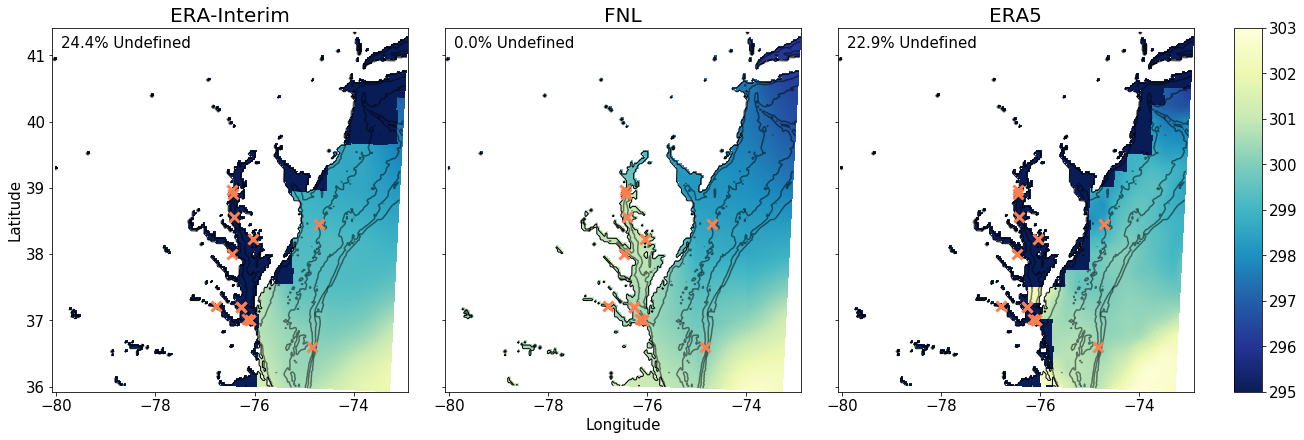

In [10]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(18,6),sharey=True,sharex=True,constrained_layout=True)
water_levels = np.arange(10.0,101.0,20.0)
for cc,case in enumerate(cases_of_interest):
    sst = sst_cases[case].where(landmask == 0.0)
    sst_plt = ax[cc].pcolormesh(lon, lat, sst, cmap=plt.cm.YlGnBu_r, norm=Normalize(295,303))
    ax[cc].contour(lon, lat, landmask,levels=[0.5],colors='k',alpha=1.0,linewidths=1.0)
    ax[cc].contour(lon, lat, water_dpth,levels=water_levels,colors='k',alpha=0.5,linestyles='-')
    ax[cc].tick_params(labelsize=15)
    pct_missing = 100.0*(np.shape(np.where(sst == 0.0))[1]/np.shape(np.where(sst >= 0.0))[1])
    ax[cc].text(-79.9,41.3,'{0:3.1f}% Undefined'.format(pct_missing),va='top',ha='left',size=15)
    if 'ERAI' in case:
        case_str = 'ERA-Interim'
    elif 'GFSR' in case:
        case_str = 'FNL'
    elif 'ERA5' in case:
        case_str = 'ERA5'
    ax[cc].set_title(case_str,size=20)
    
    
    count=0
    for ss,stn in enumerate(buoy_loc_dict):
        loc_x = buoy_loc_dict[stn]['x']
        loc_y = buoy_loc_dict[stn]['y']
        #if obs_type == 'CBIBS':
        #    if stn == 'ANN':loc_x += 1
        #elif obs_type == 'NDBC':
        ha='center'
        va='bottom'
        if stn == 'CAM':loc_y += 1; ha = 'left'
        if stn == 'SLM':loc_x += 1
        if stn == 'ANN': ha = 'right'; va = 'bottom'
        if stn == 'THP': ha = 'left'; va = 'bottom'
        if stn == 'BIS': ha = 'left'; va = 'bottom'
        if stn == 'GOO': ha = 'right'; va = 'bottom'
        if stn == 'GRF': ha = 'right'; va = 'top'
        if stn == 'FLN': ha = 'center'; va = 'top'
        if stn == 'LWT': ha = 'right'; va = 'center'
        if stn == 'PMC': ha = 'left'; va = 'center'
        if landmask[loc_y,loc_x] == 1:
            mc = 'r'
        else:
            mc = 'k'
            ax[cc].scatter(buoy_loc_dict[stn]['lon'],buoy_loc_dict[stn]['lat'],marker='x',s=100,c='coral',lw=3.0,zorder=5)
            #ax[cc].text(buoy_loc_dict[stn]['lon'],buoy_loc_dict[stn]['lat'],stn,size=20,va=va,ha=ha)  

    
    
    
    
sst_cbar = fig.colorbar(sst_plt, ax=ax[:],aspect=40.0)
sst_cbar.ax.tick_params(labelsize=15)
ax[0].set_ylabel('Latitude',size=15)
ax[1].set_xlabel('Longitude',size=15)
plt.show()

# New SST plots

In [11]:
cases_of_interest = [
                     'GFSR_YSU_CHRN_GFS_NOSK_3DOM',
                     'GFSR_YSU_CHRN_GHR_NOSK_3DOM',
                     'GFSR_YSU_CHRN_MOD_NOSK_3DOM',
                     'ERAI_YSU_CHRN_OST_NOSK_4DOM',
                     'ERAI_YSU_CHRN_GHR_NOSK_3DOM',
                     'ERAI_YSU_CHRN_MOD_NOSK_3DOM',
                     'ERA5_YSU_CHRN_ER5_NOSK_3DOM',
                     'ERA5_YSU_CHRN_ER5_OVER_3DOM',
                     'ERAI_YSU_CHRN_OST_OVER_3DOM',
                    ]

In [12]:
wrfin = xr.open_dataset('{}{}/{}/wrfinput_d03'.format(wrf_dir,'ERAI_YSU_JMNZ_OST_NOSK_3DOM',restarts[0]))

landmask = np.squeeze(wrfin.LANDMASK)
lat = np.squeeze(wrfin.XLAT)
lon = np.squeeze(wrfin.XLONG)
water_dpth = np.squeeze(wrfin.WATER_DEPTH)

wrfin.close()

sst_cases = {}
vel_cases = {}
t2_cases = {}

for cc,case in enumerate(cases_of_interest):
    file_paths = []
    dom = int(str(case_dict[case].keys()).split("'")[1].replace('d0',''))
    f_dir = '{}{}/{}/'.format(wrf_dir,case,'{}')

    f_list = sorted(glob.glob('{}wrfout_d0{}*'.format(f_dir.format(restarts[0]),dom)))
    f_list_good = f_list[n_spinup_files:]        
    for ff in f_list_good: 
        file_paths.append(ff)

    init_vars = True
    wrf_f = xr.open_dataset(file_paths[0])

    sst_cases[case] = np.squeeze(wrf_f.SST)
    wrf_f.close()
    print('Finished with {}'.format(case))
    

Finished with GFSR_YSU_CHRN_GFS_NOSK_3DOM
Finished with GFSR_YSU_CHRN_GHR_NOSK_3DOM
Finished with GFSR_YSU_CHRN_MOD_NOSK_3DOM
Finished with ERAI_YSU_CHRN_OST_NOSK_4DOM
Finished with ERAI_YSU_CHRN_GHR_NOSK_3DOM
Finished with ERAI_YSU_CHRN_MOD_NOSK_3DOM
Finished with ERA5_YSU_CHRN_ER5_NOSK_3DOM
Finished with ERA5_YSU_CHRN_ER5_OVER_3DOM
Finished with ERAI_YSU_CHRN_OST_OVER_3DOM


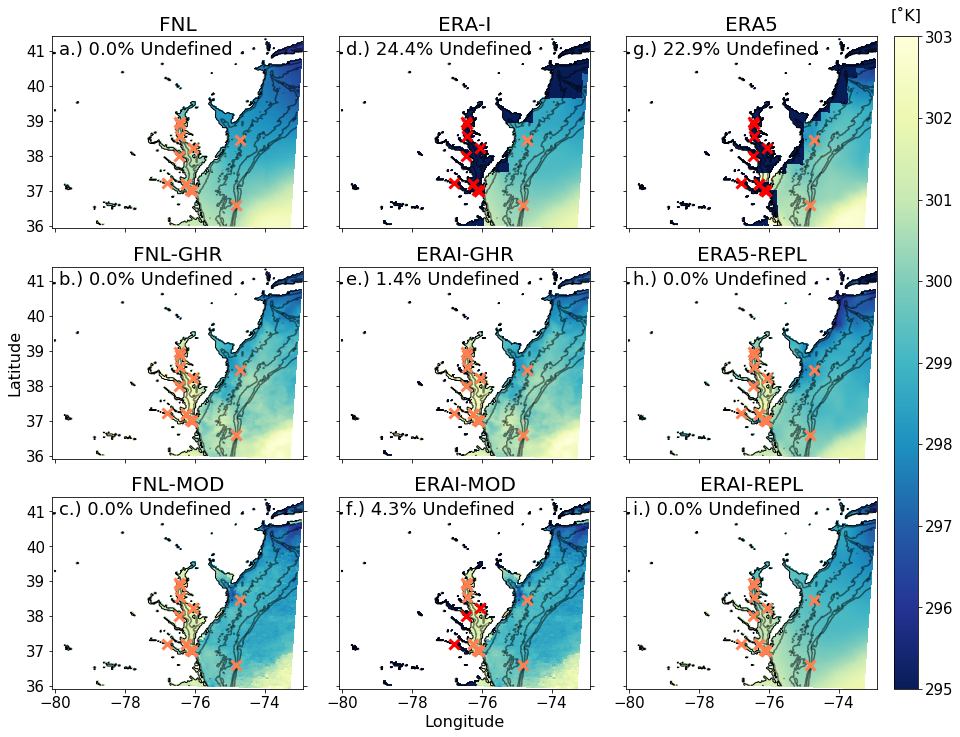

In [13]:
fig = plt.figure(figsize=(15,12))
nrows = 3
ncols = 6
c_row = 0
c_col = 0
water_levels = np.arange(10.0,101.0,20.0)

for cc,case in enumerate(cases_of_interest):
    '''
    if 'ERAI' in case:
        c_row = 0
    elif 'GFSR' in case:
        c_row = 1
    elif 'ERA5' in case:
        c_row = 2
    if ('_OST_' in case) or ('_GFS_' in case):
        c_col = 0
    elif '_GHR_' in case:
        c_col = 2
    elif '_MOD_' in case:
        c_col = 4
    if '_ER5_N' in case:
        c_col = 0
    elif '_ER5_O' in case:
        c_col = 2
    '''
    
    
    if cc == 0:
        sst_plt_ax = plt.subplot2grid((nrows,ncols),(c_row,c_col),rowspan=1,colspan=2,aspect='equal')
    else:
        sst_plt_ax = plt.subplot2grid((nrows,ncols),(c_row,c_col),rowspan=1,colspan=2,sharex=sst_plt_ax,sharey=sst_plt_ax,aspect='equal')
    sst = sst_cases[case].where(landmask == 0.0)
    sst_plt = sst_plt_ax.pcolormesh(lon, lat, sst, cmap=plt.cm.YlGnBu_r, norm=Normalize(295,303))
    sst_plt_ax.contour(lon, lat, landmask,levels=[0.5],colors='k',alpha=1.0,linewidths=1.0)
    sst_plt_ax.contour(lon, lat, water_dpth,levels=water_levels,colors='k',alpha=0.5,linestyles='-')
    for ss,stn in enumerate(buoy_loc_dict):

        loc_x = buoy_loc_dict[stn]['x']
        loc_y = buoy_loc_dict[stn]['y']

        if landmask[loc_y,loc_x] != 1:
            if sst[loc_y,loc_x] > 0.0:
                mc = 'coral'
            else:
                mc = 'r'
            sst_plt_ax.scatter(buoy_loc_dict[stn]['lon'],buoy_loc_dict[stn]['lat'],marker='x',s=100,c=mc,lw=3.0,zorder=5) 

    ylabels = False
    xlabels = False
    tick_right = False
    if c_col == 0: ylabels = True
    if c_row == 2: xlabels = True
    #if (c_row == 1) and (c_col == 4):
    #    xlabels = True
    if c_col < 3: tick_right = True
    sst_plt_ax.tick_params(labelsize=15,labelleft=ylabels,labelbottom=xlabels,right=tick_right)
    pct_missing = 100.0*(np.shape(np.where(sst == 0.0))[1]/np.shape(np.where(sst >= 0.0))[1])
    sst_plt_ax.text(-79.9,41.3,'{1}.) {0:3.1f}% Undefined'.format(pct_missing,ascii_lowercase[cc]),va='top',ha='left',size=18)    
    if (c_col == 2) and (c_row == 2):
        plt.xlabel('Longitude',size=16)
    if (c_col == 0) and (c_row == 1):
        plt.ylabel('Latitude',size=16)
    plt.title(case_dict[case]['d03']['name'],size=20)
    c_row += 1
    if c_row == 3:
        c_row = 0
        c_col += 2
cb_ax = fig.add_axes([0.91, 0.125, 0.022, 0.755])
cbar = fig.colorbar(sst_plt, cax=cb_ax)
cb_ax.tick_params(labelsize=15)
cb_ax.text(299,303.2,'[˚K]',ha='center',size=16)
plt.show()




# Visualization of bay breeze

In [9]:
obs_dir = '/glade/work/hawbecke/ATEC/Chesapeake/Data/Obs/'
awos_ds = xr.open_dataset('{}AWOS/AWOS_2019to2020.nc'.format(obs_dir))
asos_ds = xr.open_dataset('{}ASOS/ASOS_2019to2020.nc'.format(obs_dir))
apg_ds  = xr.open_dataset('{}APG/APG_data_2019.nc'.format(obs_dir))

near_shore_stations  = []
inland_station_names = []

near_shore_stations  = ['APG', 'BWI', 'MTN', 'NAK', 'NHK', 'NUI']
inland_station_names = ['ADW', 'CBE', 'CGE', 'CGS', 'CJR', 'DCA', 
                        'ESN', 'FDK', 'GAI', 'GED', 'HGR', 'IAD', 
                        'ILG', 'MIV', 'MRB', 'OXB', 'PHL', 'SBY', 
                        'W29', 'WAL']

In [10]:
apg_stn_list = list(apg_ds.station.data)
for ss,apg_stn in enumerate(apg_stn_list):
    if apg_stn == 'PAA':
        apg_stn_list[ss] = 'APG'
apg_ds = apg_ds.assign_coords({'station': apg_stn_list})
  

In [24]:
cases_of_interest = [
                     'GFSR_YSU_CHRN_GFS_NOSK_3DOM',
                     'ERAI_YSU_CHRN_OST_NOSK_4DOM',
                     'ERA5_YSU_CHRN_ER5_NOSK_3DOM',
                    ]

In [44]:
wrfin = xr.open_dataset('{}{}/{}/wrfinput_d03'.format(wrf_dir,'ERAI_YSU_JMNZ_OST_NOSK_3DOM',restarts[0]))

landmask = np.squeeze(wrfin.LANDMASK)
lat = np.squeeze(wrfin.XLAT)
lon = np.squeeze(wrfin.XLONG)
water_dpth = np.squeeze(wrfin.WATER_DEPTH)

wrfin.close()

u_cases = {}
v_cases = {}
vel_cases = {}
t2_cases = {}
#for f_ind in [36,38,40]:
#for f_ind in [35,37,39]:
for f_ind in [11,13,15]:
    
    for cc,case in enumerate(cases_of_interest):
        file_paths = []
        dom = int(str(case_dict[case].keys()).split("'")[1].replace('d0',''))
        f_dir = '{}{}/{}/'.format(wrf_dir,case,'{}')

        f_list = sorted(glob.glob('{}wrfout_d0{}*'.format(f_dir.format(restarts[0]),dom)))
        f_list_good = f_list[n_spinup_files:]        
        for f,ff in enumerate(f_list_good): 
            file_paths.append(ff)

        init_vars = True
        wrf_f = xr.open_dataset(file_paths[f_ind])
        wrf_time = wrf_f.Time.XTIME.data[0]
        if cc == 0:
            u_cases[wrf_time]   = {}
            v_cases[wrf_time]   = {}
            vel_cases[wrf_time] = {}
            t2_cases[wrf_time]  = {}

        u_cases[wrf_time][case]   = np.squeeze(wrf_f.U10)*cosalpha - np.squeeze(wrf_f.V10)*sinalpha
        v_cases[wrf_time][case]   = np.squeeze(wrf_f.V10)*cosalpha + np.squeeze(wrf_f.U10)*sinalpha
        vel_cases[wrf_time][case] = np.squeeze((wrf_f.U10**2 + wrf_f.V10**2)**0.5)
        t2_cases[wrf_time][case]  = np.squeeze(wrf_f.TH2)
        
        wrf_f.close()
        print('Finished with {}'.format(case))


Finished with GFSR_YSU_CHRN_GFS_NOSK_3DOM
Finished with ERAI_YSU_CHRN_OST_NOSK_4DOM
Finished with ERA5_YSU_CHRN_ER5_NOSK_3DOM
Finished with GFSR_YSU_CHRN_GFS_NOSK_3DOM
Finished with ERAI_YSU_CHRN_OST_NOSK_4DOM
Finished with ERA5_YSU_CHRN_ER5_NOSK_3DOM
Finished with GFSR_YSU_CHRN_GFS_NOSK_3DOM
Finished with ERAI_YSU_CHRN_OST_NOSK_4DOM
Finished with ERA5_YSU_CHRN_ER5_NOSK_3DOM


GFSR_YSU_CHRN_GFS_NOSK_3DOM
ERAI_YSU_CHRN_OST_NOSK_4DOM
ERA5_YSU_CHRN_ER5_NOSK_3DOM


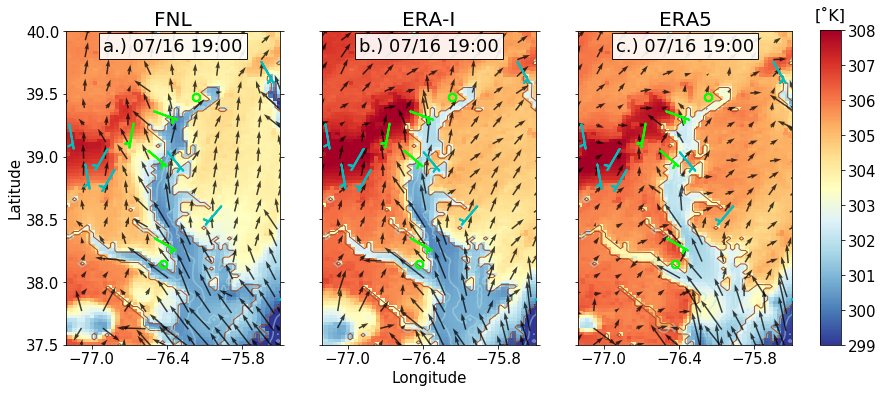

In [101]:
fig = plt.figure(figsize=(13,7))

water_levels = np.arange(10.0,101.0,20.0)
avail_times = list(u_cases.keys())
toi = avail_times[1]
for cc,case in enumerate(cases_of_interest):
    if cc == 0:
        plt_ax = plt.subplot2grid((1,3),(0,cc),aspect='equal')
    else:
        plt_ax = plt.subplot2grid((1,3),(0,cc),aspect='equal',sharex=plt_ax,sharey=plt_ax)
        
    print(case)
    u = u_cases[toi][case]
    v = v_cases[toi][case]
    vel = vel_cases[toi][case]
    t2 = t2_cases[toi][case]

    vel_plt = plt.pcolormesh(lon, lat, t2, cmap=plt.cm.RdYlBu_r, norm=Normalize(299,308))
    quiv_int = 5
    quiv = plt.quiver(lon[::quiv_int,::quiv_int],lat[::quiv_int,::quiv_int],
                         u[::quiv_int,::quiv_int],v[::quiv_int,::quiv_int],
                         scale=50.0,color='k',
                         width=0.007,
                         alpha=0.75,
                         zorder=4)
    plt.contour(lon, lat, landmask,levels=[0.5],colors='sienna',alpha=1.0,linewidths=1.0)
    plt.contour(lon, lat, water_dpth,levels=water_levels,colors='powderblue',alpha=0.5,linestyles='-')
    
    for ss,stn in enumerate(near_shore_stations):

        stn_c = 'mediumseagreen'
        stn_c = 'lime'
        if stn == 'APG':
            stn_ds = apg_ds.sel(station=stn)
        elif stn in awos_ds.station:
            stn_ds = awos_ds.sel(station=stn)
        elif stn in asos_ds.station:
            stn_ds = asos_ds.sel(station=stn)
        stn_lat  = stn_ds.lat
        stn_lon  = stn_ds.lon
        stn_wspd = stn_ds.wspd.dropna(how='any',dim='datetime').sel(datetime=toi, method='nearest',tolerance='15m')
        wspd_time = stn_wspd.datetime.data
        toi_ds = stn_ds.sel(datetime=wspd_time)
        stn_u,stn_v = calc_uv(toi_ds)
        #print('{0}\t{1:3.1f}\t{2:3.1f}\t{3:3.1f}'.format(stn,stn_u.data,stn_v.data,stn_wspd.data))
        plt.barbs(stn_lon,stn_lat,stn_u,stn_v,zorder=5,color=stn_c,lw=2.0,rounding=True,pivot='middle')


    for ss,stn in enumerate(inland_station_names):

        stn_c = 'mediumseagreen'
        stn_c = 'c'
        if stn == 'APG':
            stn_ds = apg_ds.sel(station=stn)
        elif stn in awos_ds.station:
            stn_ds = awos_ds.sel(station=stn)
        elif stn in asos_ds.station:
            stn_ds = asos_ds.sel(station=stn)
        stn_lat  = stn_ds.lat
        stn_lon  = stn_ds.lon
        stn_wspd = stn_ds.wspd.dropna(how='any',dim='datetime').sel(datetime=toi, method='nearest',tolerance='15m')
        if stn_wspd >= 2.5:
            wspd_time = stn_wspd.datetime.data
            toi_ds = stn_ds.sel(datetime=wspd_time)
            stn_u,stn_v = calc_uv(toi_ds)
            #print('{0}\t{1:3.1f}\t{2:3.1f}\t{3:3.1f}'.format(stn,stn_u.data,stn_v.data,stn_wspd.data))
            plt.barbs(stn_lon,stn_lat,stn_u,stn_v,zorder=5,color=stn_c,lw=2.0,rounding=True,pivot='middle')

    plt.tick_params(labelsize=15)

    case_str = case_dict[case]['d03']['name']
    plt.title(case_str,size=20)
            
    if cc > 0:
        plt.tick_params(labelleft=False)        
    if cc < 2:
        plt.tick_params(right=True)                
    plt.xticks(np.arange(-77.0,-75.5,0.6))
    if cc == 0: plt.ylabel('Latitude',size=15)
    if cc == 1: plt.xlabel('Longitude',size=15)
    plt.text(-76.35,39.95,'{}.) {}'.format(ascii_lowercase[cc],pd.to_datetime(toi).strftime('%m/%d %H:%M')),
             size=18,ha='center',va='top',bbox=dict(fc="w",alpha=0.9),zorder=5)
    plt.ylim(37.5,40.0)
    plt.xlim(-77.2,-75.5)

cb_ax = fig.add_axes([0.93, 0.19, 0.022, 0.625])
cbar = fig.colorbar(vel_plt, cax=cb_ax)
cb_ax.tick_params(labelsize=15)
cb_ax.text(303.5,308.3,'[˚K]',ha='center',size=16)
plt.show()

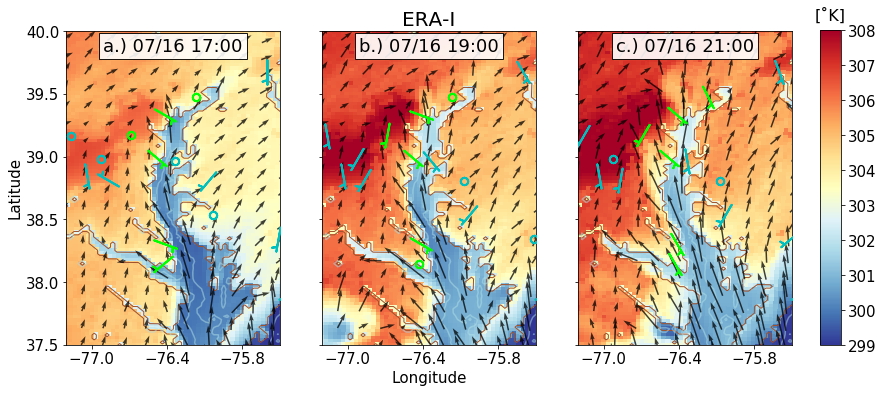

In [100]:
fig = plt.figure(figsize=(13,7))
water_levels = np.arange(10.0,101.0,20.0)

case = cases_of_interest[1]
for tt,toi in enumerate(avail_times):
    if tt == 0:
        plt_ax = plt.subplot2grid((1,3),(0,tt),aspect='equal')
    else:
        plt_ax = plt.subplot2grid((1,3),(0,tt),aspect='equal',sharex=plt_ax,sharey=plt_ax)
     
    u = u_cases[toi][case]
    v = v_cases[toi][case]
    vel = vel_cases[toi][case]
    t2 = t2_cases[toi][case]
    vel_plt = plt.pcolormesh(lon, lat, t2, cmap=plt.cm.RdYlBu_r, norm=Normalize(299,308))
    quiv_int = 5
    quiv = plt.quiver(lon[::quiv_int,::quiv_int],lat[::quiv_int,::quiv_int],
                         u[::quiv_int,::quiv_int],v[::quiv_int,::quiv_int],
                         scale=50.0,color='k',
                         width=0.007,
                         alpha=0.75,
                         zorder=4)
    plt.contour(lon, lat, landmask,levels=[0.5],colors='sienna',alpha=1.0,linewidths=1.0)
    plt.contour(lon, lat, water_dpth,levels=water_levels,colors='powderblue',alpha=0.5,linestyles='-')
    plt.tick_params(labelsize=15)
    if tt == 1:
        plt.title(case_dict[case]['d03']['name'],size=20)

    for ss,stn in enumerate(near_shore_stations):
        if stn in apg_ds.station:
            stn_lat = apg_ds.sel(station=stn).lat
            stn_lon = apg_ds.sel(station=stn).lon
        elif stn in awos_ds.station:
            stn_lat = awos_ds.sel(station=stn).lat
            stn_lon = awos_ds.sel(station=stn).lon
        elif stn in asos_ds.station:
            stn_lat = asos_ds.sel(station=stn).lat
            stn_lon = asos_ds.sel(station=stn).lon

    for ss,stn in enumerate(near_shore_stations):
        
        stn_c = 'lime'
        if stn == 'APG':
            stn_ds = apg_ds.sel(station=stn)
        elif stn in awos_ds.station:
            stn_ds = awos_ds.sel(station=stn)
        elif stn in asos_ds.station:
            stn_ds = asos_ds.sel(station=stn)
        stn_lat  = stn_ds.lat
        stn_lon  = stn_ds.lon
        try:
            stn_wspd = stn_ds.wspd.dropna(how='any',dim='datetime').sel(datetime=toi, method='nearest',tolerance='15m')
        except KeyError:
            print(stn)
        else:
            wspd_time = stn_wspd.datetime.data
            toi_ds = stn_ds.sel(datetime=wspd_time)
            stn_u,stn_v = calc_uv(toi_ds)
            plt.barbs(stn_lon,stn_lat,stn_u,stn_v,zorder=5,color=stn_c,lw=2.0,rounding=True,pivot='middle')


    for ss,stn in enumerate(inland_station_names):
        
        stn_c = 'c'
        if stn == 'APG':
            stn_ds = apg_ds.sel(station=stn)
        elif stn in awos_ds.station:
            stn_ds = awos_ds.sel(station=stn)
        elif stn in asos_ds.station:
            stn_ds = asos_ds.sel(station=stn)
        stn_lat  = stn_ds.lat
        stn_lon  = stn_ds.lon
        try:
            stn_wspd = stn_ds.wspd.dropna(how='any',dim='datetime').sel(datetime=toi, method='nearest',tolerance='30m')
        except KeyError:
            print(stn)
        else:
            wspd_time = stn_wspd.datetime.data
            toi_ds = stn_ds.sel(datetime=wspd_time)
            stn_u,stn_v = calc_uv(toi_ds)
            plt.barbs(stn_lon,stn_lat,stn_u,stn_v,zorder=5,color=stn_c,lw=2.0,rounding=True,pivot='middle')

    if tt > 0:
        plt.tick_params(labelleft=False)
    if tt > 2:
        plt.tick_params(right=True)
    plt.xticks(np.arange(-77.0,-75.5,0.6))
    if tt == 0: plt.ylabel('Latitude',size=15)
    if tt == 1: plt.xlabel('Longitude',size=15)
    plt.text(-76.35,39.95,'{}.) {}'.format(ascii_lowercase[tt],pd.to_datetime(toi).strftime('%m/%d %H:%M')),
             size=18,ha='center',va='top',bbox=dict(fc="w",alpha=0.9),zorder=5)
    plt.ylim(37.5,40.0)
    plt.xlim(-77.2,-75.5)
    
cb_ax = fig.add_axes([0.93, 0.19, 0.022, 0.625])
cbar = fig.colorbar(vel_plt, cax=cb_ax)
cb_ax.tick_params(labelsize=15)
cb_ax.text(303.5,308.3,'[˚K]',ha='center',size=16)

plt.show()

# Plot domains:

In [90]:
wrfin1 = xr.open_dataset('{}{}/{}/wrfinput_d01'.format(wrf_dir,'ERAI_YSU_JMNZ_OST_NOSK_3DOM',restarts[0]))
wrfin2 = xr.open_dataset('{}{}/{}/wrfinput_d02'.format(wrf_dir,'ERAI_YSU_JMNZ_OST_NOSK_3DOM',restarts[0]))
wrfin3 = xr.open_dataset('{}{}/{}/wrfinput_d03'.format(wrf_dir,'ERAI_YSU_JMNZ_OST_NOSK_3DOM',restarts[0]))


In [128]:
landmask_d01 = np.squeeze(wrfin1.LANDMASK)
hgt_d01 = np.squeeze(wrfin1.HGT)
lat_d01 = np.squeeze(wrfin1.XLAT)
lon_d01 = np.squeeze(wrfin1.XLONG)

landmask_d02 = np.squeeze(wrfin2.LANDMASK)
hgt_d02 = np.squeeze(wrfin2.HGT)
lat_d02 = np.squeeze(wrfin2.XLAT)
lon_d02 = np.squeeze(wrfin2.XLONG)

landmask_d03 = np.squeeze(wrfin3.LANDMASK)
hgt_d03 = np.squeeze(wrfin3.HGT)
lat_d03 = np.squeeze(wrfin3.XLAT)
lon_d03 = np.squeeze(wrfin3.XLONG)

In [114]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def outline_dom(var):
    var = var*0.0
    var[:,0] = 1.0
    var[:,-1] = 1.0
    var[0,:] = 1.0
    var[-1,:] = 1.0
    return(var)


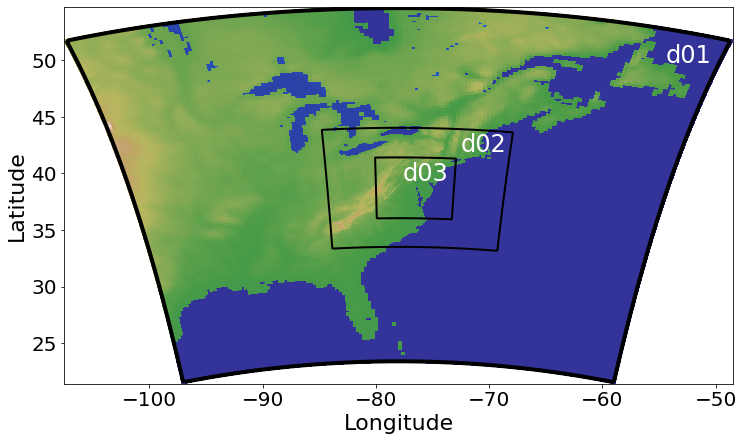

In [218]:
fig = plt.figure(figsize=(12,12))

plt.subplot(111,aspect='equal')
hgt_min,hgt_max = np.min(hgt_d01),np.max(hgt_d01)

test_hgt = hgt_d01.copy()
test_hgt.where(landmask_d01 == 0.0)

land_cmap = truncate_colormap(plt.cm.gist_earth, 0.45, 1.0)
water_cmap = truncate_colormap(plt.cm.terrain, 0.0, 0.25)

plt.pcolormesh(lon_d01, lat_d01, hgt_d01, norm=Normalize(hgt_min,hgt_max), cmap=water_cmap)
plt.pcolormesh(lon_d01, lat_d01, hgt_d01.where(landmask_d01 == 1.0), norm=Normalize(hgt_min,hgt_max), cmap=land_cmap)


plt.pcolormesh(lon_d02, lat_d02, hgt_d02, norm=Normalize(hgt_min,hgt_max), cmap=water_cmap)
plt.pcolormesh(lon_d02, lat_d02, hgt_d02.where(landmask_d02 == 1.0), norm=Normalize(hgt_min,hgt_max), cmap=land_cmap)

plt.pcolormesh(lon_d03, lat_d03, hgt_d03, norm=Normalize(hgt_min,hgt_max), cmap=water_cmap)
plt.pcolormesh(lon_d03, lat_d03, hgt_d03.where(landmask_d03 == 1.0), norm=Normalize(hgt_min,hgt_max), cmap=land_cmap)





d01_outline = outline_dom(landmask_d01)
d02_outline = outline_dom(landmask_d02)
d03_outline = outline_dom(landmask_d03)

plt.contour(lon_d01, lat_d01, d01_outline,colors='k', levels=[0.5], linewidths=4.0)
plt.text(1.04*np.max(lon_d01),0.94*np.max(lat_d01),'d01',size=24, va='top', ha='right', color='w')

plt.contour(lon_d02, lat_d02, d02_outline,colors='k', levels=[0.5], linewidths=2.0)
plt.text(1.01*np.max(lon_d02),0.99*np.max(lat_d02),'d02',size=24, va='top', ha='right', color='w')

plt.contour(lon_d03, lat_d03, d03_outline,colors='k', levels=[0.5], linewidths=2.0)
plt.text(1.01*np.max(lon_d03),0.99*np.max(lat_d03),'d03',size=24, va='top', ha='right', color='w')


plt.tick_params(labelsize=20)
plt.xlabel('Longitude',size=22)
plt.ylabel('Latitude',size=22)
plt.show()

In [11]:
cases_of_interest = ['ERAI_YSU_CHRN_OST_SKNT_3DOM','ERAI_YSU_CHRN_GHR_SKNT_3DOM','ERAI_YSU_CHRN_MOD_SKNT_3DOM']

In [19]:
tsk_cases   = {}
sstsk_cases = {}

for cc,case in enumerate(cases_of_interest):
    file_paths = []
    dom = int(str(case_dict[case].keys()).split("'")[1].replace('d0',''))
    f_dir = '{}{}/{}/'.format(wrf_dir,case,'{}')

    f_list = sorted(glob.glob('{}wrfout_d0{}*'.format(f_dir.format(restarts[0]),dom)))
    f_list_good = f_list[n_spinup_files:]        
    for ff in f_list_good: 
        file_paths.append(ff)

    init_vars = True
    wrf_f = xr.open_dataset(file_paths[10])

    tsk_cases[case]   = np.squeeze(wrf_f.TSK)
    sstsk_cases[case] = np.squeeze(wrf_f.SSTSK)
    print('Finished with {}'.format(case))
    wrf_f.close()

Finished with ERAI_YSU_CHRN_OST_SKNT_3DOM
Finished with ERAI_YSU_CHRN_GHR_SKNT_3DOM
Finished with ERAI_YSU_CHRN_MOD_SKNT_3DOM


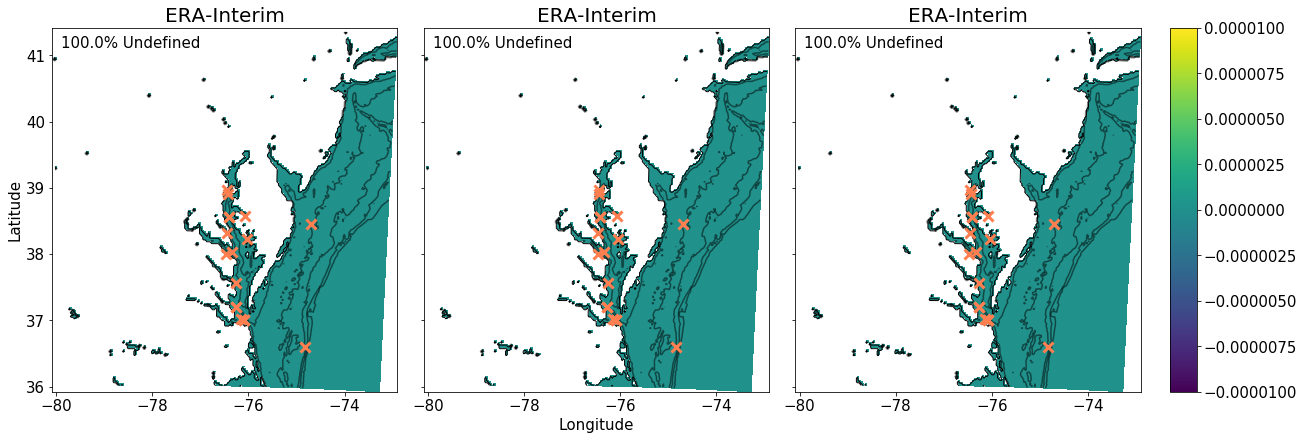

In [25]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(18,6),sharey=True,sharex=True,constrained_layout=True)
water_levels = np.arange(10.0,101.0,20.0)
for cc,case in enumerate(cases_of_interest):
    sst = tsk_cases[case].where(landmask == 0.0) - sstsk_cases[case].where(landmask == 0.0)
    sst_plt = ax[cc].pcolormesh(lon, lat, sst, cmap=plt.cm.viridis, norm=Normalize(-1e-5,1e-5))
    ax[cc].contour(lon, lat, landmask,levels=[0.5],colors='k',alpha=1.0,linewidths=1.0)
    ax[cc].contour(lon, lat, water_dpth,levels=water_levels,colors='k',alpha=0.5,linestyles='-')
    ax[cc].tick_params(labelsize=15)
    pct_missing = 100.0*(np.shape(np.where(sst == 0.0))[1]/np.shape(np.where(sst >= 0.0))[1])
    ax[cc].text(-79.9,41.3,'{0:3.1f}% Undefined'.format(pct_missing),va='top',ha='left',size=15)
    if 'ERAI' in case:
        case_str = 'ERA-Interim'
    elif 'GFSR' in case:
        case_str = 'GFS'
    elif 'ERA5' in case:
        case_str = 'ERA5'
    ax[cc].set_title(case_str,size=20)
    
    
    count=0
    for ss,stn in enumerate(buoy_loc_dict):
        loc_x = buoy_loc_dict[stn]['x']
        loc_y = buoy_loc_dict[stn]['y']
        #if obs_type == 'CBIBS':
        #    if stn == 'ANN':loc_x += 1
        #elif obs_type == 'NDBC':
        ha='center'
        va='bottom'
        if stn == 'CAM':loc_y += 1; ha = 'left'
        if stn == 'SLM':loc_x += 1
        if stn == 'ANN': ha = 'right'; va = 'bottom'
        if stn == 'THP': ha = 'left'; va = 'bottom'
        if stn == 'BIS': ha = 'left'; va = 'bottom'
        if stn == 'GOO': ha = 'right'; va = 'bottom'
        if stn == 'GRF': ha = 'right'; va = 'top'
        if stn == 'FLN': ha = 'center'; va = 'top'
        if stn == 'LWT': ha = 'right'; va = 'center'
        if stn == 'PMC': ha = 'left'; va = 'center'
        if landmask[loc_y,loc_x] == 1:
            mc = 'r'
        else:
            mc = 'k'
            ax[cc].scatter(buoy_loc_dict[stn]['lon'],buoy_loc_dict[stn]['lat'],marker='x',s=100,c='coral',lw=3.0,zorder=5)
            #ax[cc].text(buoy_loc_dict[stn]['lon'],buoy_loc_dict[stn]['lat'],stn,size=20,va=va,ha=ha)  

    
    
    
    
sst_cbar = fig.colorbar(sst_plt, ax=ax[:],aspect=40.0)
sst_cbar.ax.tick_params(labelsize=15)
ax[0].set_ylabel('Latitude',size=15)
ax[1].set_xlabel('Longitude',size=15)
plt.show()